In [1]:
%cd ..

/mnt/home/c4/satnogs/optical/stvid


/home/kerel/.virtualenvs/stvid/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from stvid.fourframe import AstrometricCatalog
import configparser

In [3]:
# Read STVID config
conf_file = "configuration.ini"


cfg = configparser.ConfigParser(inline_comment_prefixes=("#", ":"))
result = cfg.read(conf_file)
if not result:
    print("Could not read config file: %s\nExiting..." % conf_file)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from datetime import datetime, timedelta

from astropy.coordinates import EarthLocation, AltAz, SkyCoord, ICRS, Angle, get_sun, GCRS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.constants import R_earth
from astropy.time import Time
from astropy.timeseries import TimeSeries

from earthshadow import show_shadow_region, EARTH_RADIUS, get_shadow_center, get_shadow_radius

### Load PolarPlotter from skyplots.py

Enable autoreload to help during development.

In [5]:
from skyplots import PolarPlotter

In [6]:
%load_ext autoreload
%autoreload 2

## Load (stvid) configuration & input values

In [7]:

# Set location
loc = EarthLocation(lat=cfg.getfloat("Observer", "latitude") * u.deg,
                    lon=cfg.getfloat("Observer", "longitude") * u.deg,
                    height=cfg.getfloat("Observer", "height") * u.m)
time = Time('2023-11-05T00:00:00', format='isot', scale='utc')
# orbit_alt = cfg.getfloat("Setup", "max_altitude") * u.km
orbit_alt = 30_000 * u.km

altaz = AltAz(alt=50 * u.deg,
              az=170 * u.deg,
              obstime=time,
              location=loc)

## Explore "earthshadow" library

<https://github.com/guynir42/earthshadow>

### Calculate anti-sun point & Compare to earthshadow results

In [8]:
def get_anti_sun(time):
    # Source: earthshadow library
    sun = get_sun(time)
    
    
    # Get the anti-sun position in geocentric ecliptic coordinates,
    # at the orbit distance
    anti_sun = SkyCoord(
        ra=np.mod(sun.ra + 180 * u.deg, 360 * u.deg),
        dec=-sun.dec,
        frame=GCRS(obstime=time),  # geocentric
        distance=orbit_alt + R_earth,
    )
    return anti_sun

get_anti_sun(time)

<SkyCoord (GCRS: obstime=2023-11-05T00:00:00.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, km)
    (39.53167693, 15.4246, 36378.1)>

In [9]:
# Compare anti_sun and shadow center
a = get_anti_sun(time).transform_to(altaz)
b = get_shadow_center(time, obs=loc, orbit=orbit_alt + R_earth).transform_to(altaz)
print(a)
print(b)

<SkyCoord (AltAz: obstime=2023-11-05T00:00:00.000, location=(4013491.18899789, 500582.5540941, 4915351.31538171) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, km)
    (198.45656596, 46.78737201, 31465.12677582)>
<SkyCoord (AltAz: obstime=2023-11-05T00:00:00.000, location=(4013491.18899789, 500582.5540941, 4915351.31538171) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (198.46271489, 46.89548473)>


This matches sufficently, both values are not expected to be equal anyway.

## Create polar plot with shadow of Earth

2023-11-05T00:00:00.000


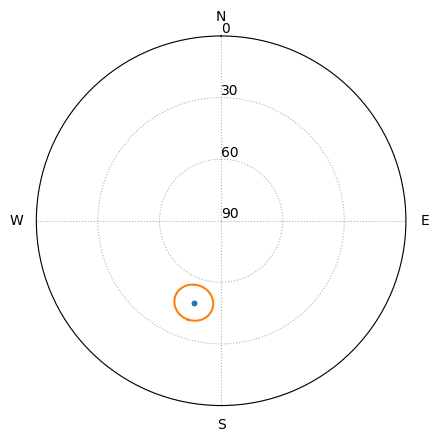

In [10]:
def plot_earth_shadow(pp, time, loc, orbit_alt):
    # Get the anti-sun point for comparison
    anti_sun = get_anti_sun(time)
    
    # Get the center of the shadow in the sky
    center = get_shadow_center(time, obs=loc, orbit=orbit_alt + R_earth)
    radius = get_shadow_radius(orbit=orbit_alt + R_earth, geocentric_orbit=True)

    center.obstime = time
    
    # Create circle on sphere around the shadow center
    center_obs = center.transform_to(AltAz(location=loc, obstime=time))
    circle = SphericalCircle(center=center_obs, radius=radius).get_xy()
    
    pp.plot_altaz(alt=circle[:,1],
                    az=circle[:,0],
                    axes_kw={'color': 'C1'}
                   )
    pp.plot_skycoord(coord=center, loc=loc)
    pp.plot_skycoord(coord=anti_sun, loc=loc,
                    axes_kw={'marker': '.',
                             'color': 'C0'})

orbit_alt = 35_700 * u.km
print(time)
pp = PolarPlotter()
plot_earth_shadow(pp, time, loc, orbit_alt)
plt.show()

# Plot earth shadow during the night

Altitude of orbit: 1200 km
Location: Bonn, DE
Time: 2023-11-05T18:00:00.000 (+ 12 hours)


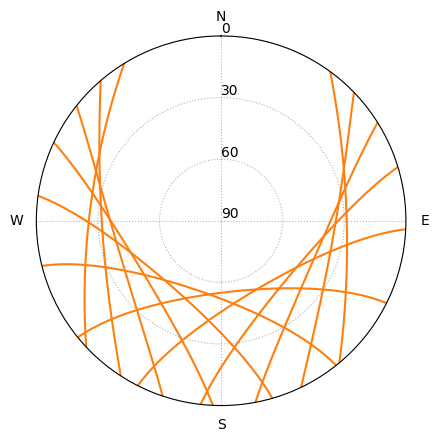

In [11]:
loc = EarthLocation(lat=cfg.getfloat("Observer", "latitude") * u.deg,
                    lon=cfg.getfloat("Observer", "longitude") * u.deg,
                    height=cfg.getfloat("Observer", "height") * u.m)
time = Time('2023-11-05T18:00:00', format='isot', scale='utc')
orbit_alt = 1_200 * u.km

ts = TimeSeries(time_start=time,
                time_delta=3600 * u.s,
                n_samples=12)

pp = PolarPlotter()
for row in ts:
    t = row[0]
    plot_earth_shadow(pp, t, loc, orbit_alt)
print(f'Altitude of orbit: {orbit_alt:.0f}')
print(f'Location: Bonn, DE')
print(f'Time: {time} (+ 12 hours)')

# ------------------------

# Example usage of the PolarPlotter

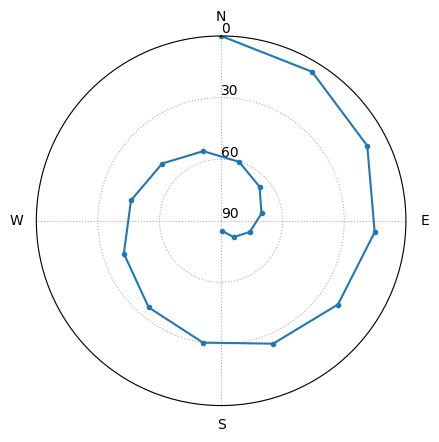

In [12]:

alt = np.arange(0, 90, 5)
az = 2 * np.pi * alt

pp = PolarPlotter()
pp.plot_altaz(alt, az)
plt.show()

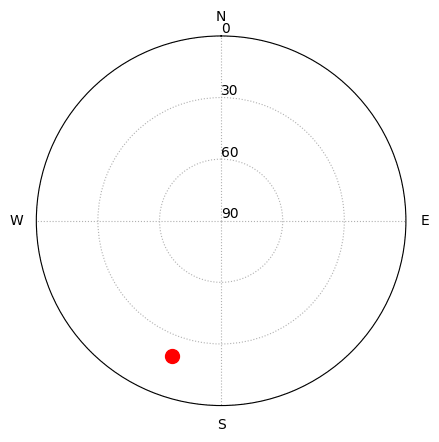

In [13]:
# Use my polar map method

coord = SkyCoord(alt = 20*u.deg,
         az = 200*u.deg,
         obstime=time,
         frame='altaz',
         location=loc) # .transform_to(ICRS)
pp = PolarPlotter()
pp.plot_skycoord(coord=coord, loc=loc,
                axes_kw={'marker': 'o',
                         'color': 'r',
                         'markersize': 10})
plt.show()